# 군집 - DBSCAN(3)

## 학습 조건 설정

### API 확인

```python
class sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric = 'euclidean',
metric_params=None, algorithm = "auto", leaf_size = 30, p = None, n_jobs=None)
```

#### 주요 파라미터

| 파라미터 | 설명 |
| -- | -- |
| `eps` | 하나의 샘플에 대한 다른 샘플과의 최대 거리 |
| `min_samples` | MinPts. 핵심 포인트로 간주할 포인트에 대한 이웃의 샘플 수 |
| metric | 피쳐 배열에서 인스턴스 간의 거리를 계산할 때 사용되는 방법. 문자열 파라미터일 경우 "euclidean"로 명시. 그렇지 않을 경우 콜백 함수 지정 |
| metric_params | metric이 콜백 함수로 지정될 경우 사용되는 파라미터 |
| n_jobs | 실행할 병렬 작업의 수. CPU의 프로세스 수만큼 설정 가능. -1은 모든 프로세서를 사용함을 의미. |

->  DBSCAN에서 가장 중요한 포인트는 `eps`와 `min_samples`의 값을 결정하는 것.

입력 파라미터인 eps와 min_samples의 값을 구할 수 있는 공식은 없음.

다만, 이를 결정하는데 도움을 받을 수 있는 주관적인 방법이 존재.(시각화 자료를 통한 분석)

### `MinPts(min_samples)`

주로 4 아니면 5.
2차원 데이터를 대상으로 실험을 진행한 결과 4, 5 이상 간에는 큰 변동이 없음.

MinPts 값이 점점 커질 수록 연산량이 상당히 커지는 경향이 있으므로 2차원 데이터에서는 MinPts 값을 4로 설정하는 것을 권장.

### `eps`

`sorted-k-dist` 그래프를 통해 eps 값을 찾는다

#### `sorted-k-dist` 그래프 작성 방법

1. MinPts를 k개라고 했을 때, 하나의 점으로부터 k개의 가장 가까운 점들간의 거리(`k-dist`)를 구한다.
2. k-dist를 내림차순으로 정렬.
3. 정렬 결과를 lineplot으로 시각화해 기울기가 급격하게 변하는 지점의 eps 값을 선정.

해당 분야 전문가가 제안하는 도메인 지식이 가장 우선 되어야 한다.

### Ref.

> Martin Ester, Hans-Peter Kriegel, Jorg Sander, Xiaowei Xu, 1996, "A Density-Based Algorithm for DiscoveringClusters in Large Spatial Databases with Noise", KDD-96

추가 참고 사이트
1. https://aboutnlp.tistory.com/59
2. https://rfriend.tistory.com/588
3. https://mjs1995.tistory.com/189

## #01. 패키지

In [46]:
import sys
import numpy as np
import seaborn as sb
from pandas import read_excel
from matplotlib import pyplot as plt

# 2개의 list를 사용해 조합을 만들어주는 패키지
from itertools import combinations 
from itertools import product

# 클러스터 알고리즘 참조
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
# 평가
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score

## #02. 데이터셋

In [32]:
origin = read_excel("https://data.hossam.kr/G02/iris.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [48]:
labels = list(origin["Species"].map({'setosa':0, "versicolor":1, "virginica":2}))
# labels

## #03. 데이터 전처리

### 1. 필요한 변수만 처리

In [33]:
origin.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
       'Species'],
      dtype='object')

In [49]:
x = origin.drop("Species", axis=1)
x[:5]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 2. 데이터 표준화

In [35]:
scaler = StandardScaler()
'''
fit_transform은 fit, transform을 결합한 형태
학습과 예측치 산정을 동시에 수행해 학습 데이터를 받을 수 없음
학습 결과를 재사용할 경우 transform() 함수를 사용'''
n_data = scaler.fit_transform(x)
n_data[:5]  #상위 5개 함수 도출

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

## #04. sorted-k-dist 그래프

-`NearestNeighbors`의 n_neighbors 파라미터 : 가까운 이웃의 수 설정(기본 값 = 5)

- `DBSCAN`의 MinPts : 핵심 포인트가 되기 위한 이웃의 수(주로 4 아니면 5)

n_neighbors = MinPts

In [36]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(n_data)   #학습
distances, indices = neighbors_fit.kneighbors(n_data)

In [50]:
distances[:5]

array([[0.        , 0.13163218, 0.13383627, 0.18772101, 0.23710977],
       [0.        , 0.16614339, 0.17890971, 0.17890971, 0.23710977],
       [0.        , 0.13383627, 0.17051228, 0.28389113, 0.31104122],
       [0.        , 0.23710977, 0.24891184, 0.2662756 , 0.28389113],
       [0.        , 0.17890971, 0.26013882, 0.27119749, 0.29154628]])

In [51]:
indices[:5]

array([[ 0, 17, 27, 40, 39],
       [ 1, 25, 12, 45, 34],
       [ 2, 47, 29,  3, 30],
       [ 3, 47, 30, 29,  2],
       [ 4, 37,  0, 40, 17]], dtype=int64)

### 정렬

In [52]:
s_distances = np.sort(distances, axis=0)
s_distances[:5]

array([[0.        , 0.        , 0.13383627, 0.17890971, 0.23710977],
       [0.        , 0.        , 0.13383627, 0.18772101, 0.23710977],
       [0.        , 0.12116787, 0.13383627, 0.18772101, 0.24891184],
       [0.        , 0.12116787, 0.13383627, 0.23710977, 0.24891184],
       [0.        , 0.12116787, 0.16614339, 0.23710977, 0.26013882]])

In [53]:
# 배열의 두 번째 열(인덱스 1)을 추출
target = s_distances[:,1]
target[:5]

array([0.        , 0.        , 0.12116787, 0.12116787, 0.12116787])

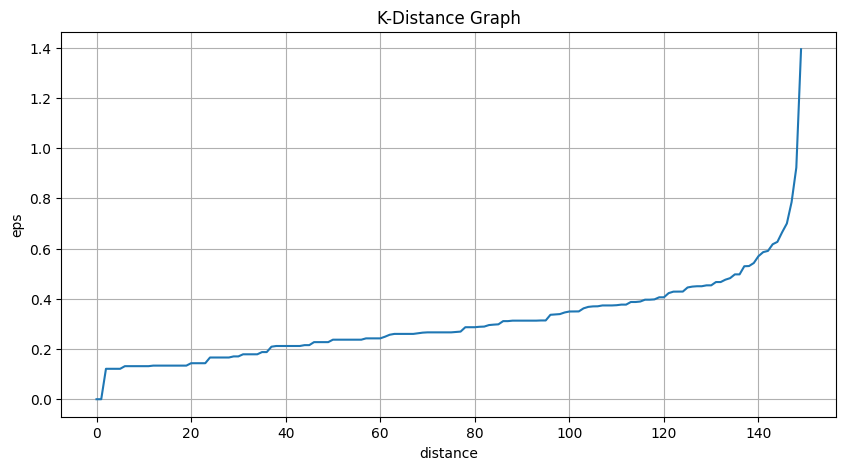

In [60]:
plt.figure(figsize=(10,5))
plt.plot(target)
plt.title("K-Distance Graph")
plt.ylabel("eps")
plt.xlabel("distance")
plt.grid()
plt.show()
plt.close()

> 경사가 급격히 변하는 지점을 확인, 그 부분이 eps.

> eps 값을 0.5, 0.6으로 설정해 군집 결과를 비교.

## #05. DBSCAN 모델 구축

### 1. 조건값 설정 

In [42]:
eps = [0.5, 0.6]
minPts = [4, 5]

In [43]:
# a = [ 1,2,3]
# list(combinations(a,2))

In [44]:
# 두 리스트의 원소를 조합해 경우의 수 생성
# 파라미터를 무제한으로 전달될 경우 *를 사용
# *는 파라미터가 가변적으로 전달될 수 있음을 나타냄.
prod = list(product(*[eps,minPts]))
prod

[(0.5, 4), (0.5, 5), (0.6, 4), (0.6, 5)]

### 2. 군집화 및 결과 평가

#### 결과 평가

| 상황 | 평가지표 |
| -- | -- |
| 목적변수가 있는 경우 | Homogeneity, Completeness, V-measure, ARI |
| 목적변수가 없는 경우 | Silhouette coefficient |

##### Homogeneity(동질성)

- 각 클러스터의 모든 객체들이 동일한 클래스로부터 온 객체들일 때, 클러스터링 결과는 동질성을 만족시킴
- `0.0에서 1.0까지의 분포를 나타내며 값이 클수록 좋음`

##### Completeness(완전성)

- 각 클래스의 모든 객체들이 동일한 클래스의 맴버가 될 때, 클러스터링 결과는 완전성을 만족시킴
- `척도 값이 클수록 좋은 알고리즘으로 평가`

##### V-measure(조화평균)

- Homogeneity와 Completeness의 조화 평균
- 동질성 및 완전성 기준이 얼마나 성공적으로 충족되었는지 명시적으로 측정
- 0.0과 1.0 사이의 양수 값을 가지며 `클 수록 좋음`
- 표본 수가 1000개 이상이고 군집 수가 10개 미만인 경우

##### ARI(Adjusted Rand Index)

- 타겟 값으로 클러스터링 결과를 평가
- 1과 0 사이의 값을 제공 `(1=최적, 0=무작위)`
- 표본의 크기가 작거나 군집 수가 많은 경우 사용
    - 기술의 발달로 표본의 크기보다 군집 수를 기준으로 판단

##### Silhouette coefficient(실루엣 계수)

- 앞의 지표와 다르게 레이블이 없는 군집용 지표
- 1과 0 사이의 값을 제공 (1=최적, 0=무작위)
- 각 군집간의 거리가 얼마나 효율적으로 분리되어 있는가를 나타냄
    * 1에 가까운 값 : 근처의 다른 군집과 거리가 멀다
    * 0에 가까운 값 : 근처의 다른 군집과 거리가 가깝다
- 음수값이 나타나는 경우 : 잘못된 분류
- 클 수록 좋은 값으로 판단

> 개별 데이터가 할당된 군집 내 데이터와 얼마나 가깝게 군집화 되어있는지, 그리고 다른 군집에 있는 데이터와는 얼마나 멀리 분리되어 있는지를 수치로 나타내는 값.

>값이 크다면 군집화의 성능이 좋다고 해석

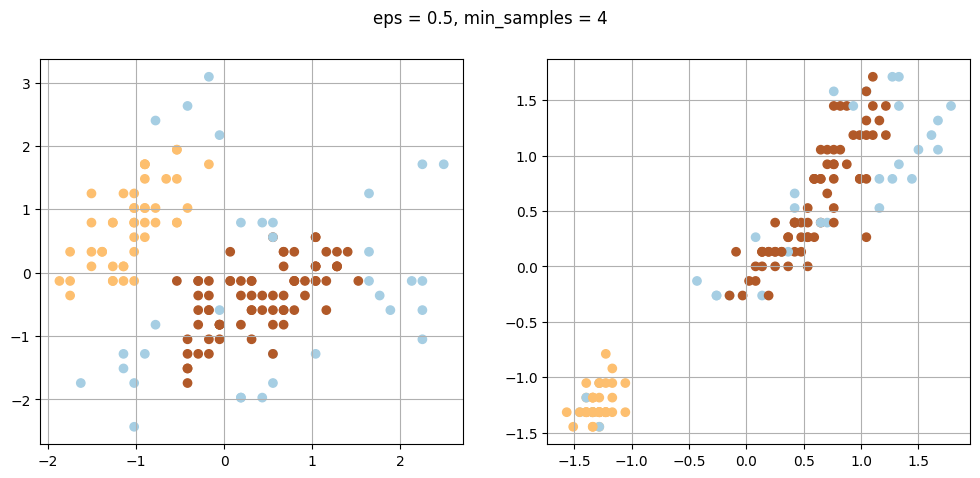

homogeneity_score : 0.5039423719520235
completeness_score : 0.5289839099785134
v_measure_score : 0.516159596250751
adjusted_rand_score : 0.44747527301949164
silhouette_score : 0.36457435678297534


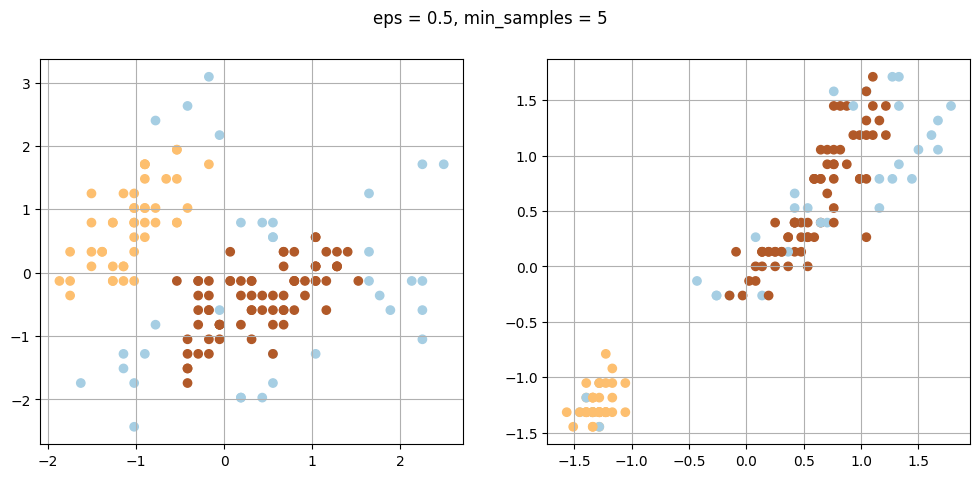

homogeneity_score : 0.5005010857048665
completeness_score : 0.522846554194579
v_measure_score : 0.5114298559522713
adjusted_rand_score : 0.4420986685885924
silhouette_score : 0.35651648142700726


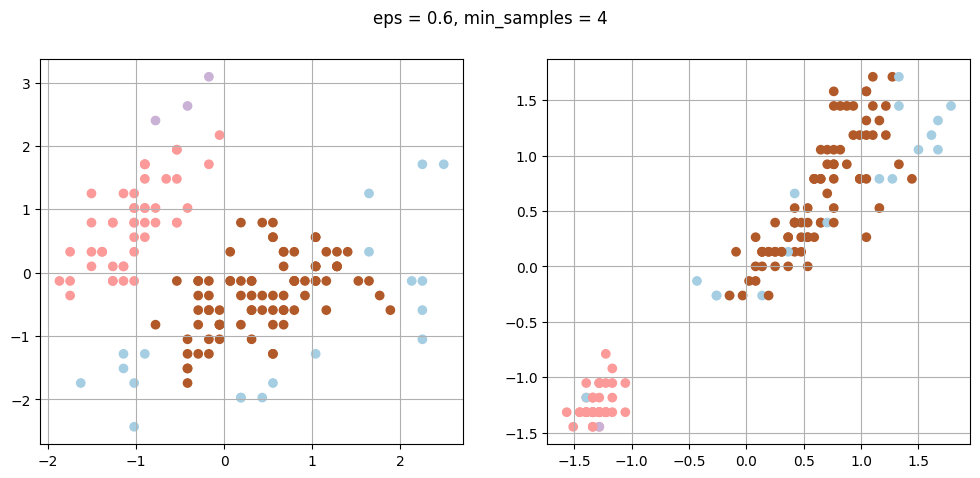

homogeneity_score : 0.5589187595325174
completeness_score : 0.5946623680973384
v_measure_score : 0.576236807549922
adjusted_rand_score : 0.48541172995292864
silhouette_score : 0.35568179506247927


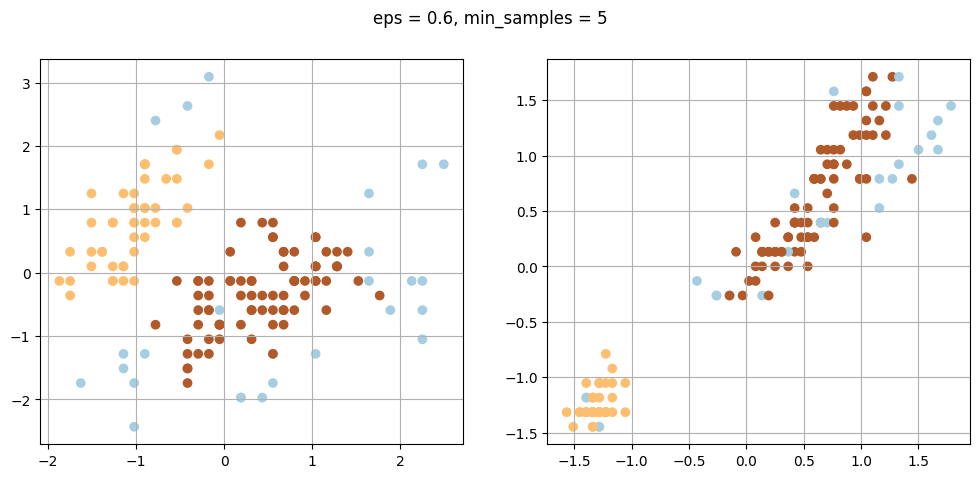

homogeneity_score : 0.5180739608524721
completeness_score : 0.5656029245001102
v_measure_score : 0.5407961567255838
adjusted_rand_score : 0.4706267335681117
silhouette_score : 0.4027617471797909


In [58]:
for e,m in prod:
    # print(e,m)
    dbscan = DBSCAN(eps=e, min_samples=m)

    # # case 1
    # dbscan.fit(n_data)
    # clusters = dbscan.labels_

    # case 2
    clusters = dbscan.fit_predict(n_data)
    # print(f"eps = {e}, min_samples = {m}")
    # print("-"*50)

    # # 군집화 그래프 생성1
    # plt.figure(figsize=(10,5))
    # plt.scatter(x=n_data[:,0], y=n_data[:,1], c=clusters, cmap="Paired")
    # plt.title("eps = %s, min_samples = %s"%(str(e), str(m)))
    # plt.show()
    # plt.close()
    
    # # 군집화 그래프 생성2
    # plt.figure(figsize=(10,5))
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
    ax1.scatter(x=n_data[:,0], y=n_data[:,1], c=clusters, cmap="Paired")
    ax2.scatter(x=n_data[:,2], y=n_data[:,3], c=clusters, cmap="Paired")
    plt.suptitle("eps = %s, min_samples = %s"%(str(e), str(m)))
    ax1.grid()
    ax2.grid()
    plt.show()
    plt.close()

    print("homogeneity_score :", homogeneity_score(labels, clusters))
    print("completeness_score :", completeness_score(labels, clusters))
    print("v_measure_score :", v_measure_score(labels, clusters))
    print("adjusted_rand_score :", adjusted_rand_score(labels, clusters))
    print("silhouette_score :", silhouette_score(n_data, clusters))

> 군집화가 비슷하다면 실행 속도가 가장 빠른 것을 사용.